# MACHINE LEARNING IN PRODUCTION MADRID - BASELINE

This is the baseline for the business case we've setup for the workshop. It is mainly a clusterization of the Spanish High Speed Rail dataset from Kaggle. We'll load this dataset that we've been building for months scrapping www.renfe.com (the official website for buying train tickets in Spain). Here is a link with the current version in Kaggle (we use to update it once a month):

https://www.kaggle.com/thegurusteam/spanish-high-speed-rail-system-ticket-pricing

## ETL

We've made a dump from our database and we've converted into a parquet file to improve the loading times and overhead of a PostgreSQL connection.

In [1]:
!aws s3 ls s3://dsla/ml-in-production-sagemaker --recursive --human-readable --summarize


2020-01-29 06:20:16   59.1 MiB ml-in-production-sagemaker/data/renfe.parquet
2020-01-29 06:20:16   18.5 MiB ml-in-production-sagemaker/data/renfe_light.parquet
2020-01-08 07:13:55  211.0 MiB ml-in-production-sagemaker/train/train.csv

Total Objects: 3
   Total Size: 288.6 MiB


In [2]:
import pandas as pd

pd.show_versions()



INSTALLED VERSIONS
------------------
commit           : None
python           : 3.7.3.final.0
python-bits      : 64
OS               : Linux
OS-release       : 3.10.0-1062.4.3.el7.x86_64
machine          : x86_64
processor        : x86_64
byteorder        : little
LC_ALL           : None
LANG             : en_US.UTF-8
LOCALE           : en_US.UTF-8

pandas           : 0.25.1
numpy            : 1.16.2
pytz             : 2018.9
dateutil         : 2.8.0
pip              : 20.0.2
setuptools       : 41.6.0
Cython           : 0.29.6
pytest           : 4.3.1
hypothesis       : None
sphinx           : 1.8.5
blosc            : None
feather          : None
xlsxwriter       : 1.1.5
lxml.etree       : 4.3.2
html5lib         : 1.0.1
pymysql          : None
psycopg2         : 2.8.3 (dt dec pq3 ext)
jinja2           : 2.10.3
IPython          : 7.4.0
pandas_datareader: None
bs4              : 4.7.1
bottleneck       : 1.2.1
fastparquet      : 0.2.1
gcsfs            : None
lxml.etree       : 4.3.2
mat

In [3]:
#TypeError: unhashable type: 'dict'
#https://stackoverflow.com/questions/52997610/python-pandas-describe-throwing-error-unhashable-type-dict


In [4]:
import pandas as pd
import pyarrow.parquet as pq
import s3fs


path = "renfe.parquet"
bucket = "dsla"
folder = "ml-in-production/data" #-sagemaker
bucket_uri = f's3://{bucket}/{folder}/{path}'

table = print(bucket_uri)

s3 = s3fs.S3FileSystem()
dataset = pq.ParquetDataset(bucket_uri,filesystem=s3)
table = dataset.read_pandas()
df = table.to_pandas()

#df = pd.read_parquet(bucket_uri,engine="pyarrow")

df.head()

s3://dsla/ml-in-production/data/renfe.parquet


,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare
0,2019-08-21 03:42:10,SEVILLA,MADRID,2019-08-29 13:40:00,2019-08-29 16:10:00,AVE,47.30,Turista,Promo
1,2019-08-21 03:42:10,SEVILLA,MADRID,2019-08-29 14:45:00,2019-08-29 17:15:00,AVE,53.40,Turista,Promo
2,2019-08-21 03:42:10,SEVILLA,MADRID,2019-08-29 14:58:00,2019-08-29 17:50:00,ALVIA,NaN,Preferente,Promo
3,2019-08-21 03:42:10,SEVILLA,MADRID,2019-08-29 15:45:00,2019-08-29 18:15:00,AVE,61.45,Preferente,Promo
4,2019-08-21 03:42:10,SEVILLA,MADRID,2019-08-29 16:45:00,2019-08-29 19:17:00,AVE,60.30,Turista,Promo


## Preprocessing

### Null values

In [5]:
print(f'Dataset size: {len(df)}\n')

print('Percentage of null values:')
df.isnull().sum() / len(df) * 100

Dataset size: 10800510

Percentage of null values:


insert_date    0.000000
origin         0.000000
destination    0.000000
start_date     0.000000
end_date       0.000000
train_type     0.000000
price          6.185439
train_class    0.281070
fare           0.281070
dtype: float64

Since there is a few number of records with null values compared with the total dataset size, we can remove them to ease posterior analysis.

In [6]:
df.dropna(inplace=True)

### Encoding

We should encode the string columns as future algorithms can only handle numbers. We've used the OrdinalEncoder approach with no fixed order in columns as fare in which a certain ordering (from cheapest to most expensive could have influence). We've left it that way for the sake of simplicity.

In [7]:
from sklearn.preprocessing import OrdinalEncoder

encoder_m = OrdinalEncoder()

columns_to_encode = ['origin', 'destination', 'train_type', 'train_class', 'fare']
df.loc[:, columns_to_encode] = encoder_m.fit_transform(df[columns_to_encode])

df.head()

,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare
0,2019-08-21 03:42:10,4.0,2.0,2019-08-29 13:40:00,2019-08-29 16:10:00,2.0,47.30,4.0,8.0
1,2019-08-21 03:42:10,4.0,2.0,2019-08-29 14:45:00,2019-08-29 17:15:00,2.0,53.40,4.0,8.0
3,2019-08-21 03:42:10,4.0,2.0,2019-08-29 15:45:00,2019-08-29 18:15:00,2.0,61.45,2.0,8.0
4,2019-08-21 03:42:10,4.0,2.0,2019-08-29 16:45:00,2019-08-29 19:17:00,2.0,60.30,4.0,8.0
5,2019-08-21 03:42:10,4.0,2.0,2019-08-29 17:45:00,2019-08-29 20:17:00,2.0,60.30,4.0,8.0


### Feature Engineering

The main task here is to extract the datetime columns info into numbers (duration, time to departure...).

In [8]:
df['duration'] = (df['end_date'] - df['start_date']).dt.seconds / 3600

df['time_to_departure'] = (df['start_date'].dt.tz_localize('Europe/Madrid').dt.tz_convert('UTC') \
                           - df['insert_date'].dt.tz_localize('UTC')).dt.days

df['hour'] = df['start_date'].dt.hour

df['weekday'] = df['start_date'].dt.dayofweek

df.head()

,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare,duration,time_to_departure,hour,weekday
0,2019-08-21 03:42:10,4.0,2.0,2019-08-29 13:40:00,2019-08-29 16:10:00,2.0,47.30,4.0,8.0,2.500000,8,13,3
1,2019-08-21 03:42:10,4.0,2.0,2019-08-29 14:45:00,2019-08-29 17:15:00,2.0,53.40,4.0,8.0,2.500000,8,14,3
3,2019-08-21 03:42:10,4.0,2.0,2019-08-29 15:45:00,2019-08-29 18:15:00,2.0,61.45,2.0,8.0,2.500000,8,15,3
4,2019-08-21 03:42:10,4.0,2.0,2019-08-29 16:45:00,2019-08-29 19:17:00,2.0,60.30,4.0,8.0,2.533333,8,16,3
5,2019-08-21 03:42:10,4.0,2.0,2019-08-29 17:45:00,2019-08-29 20:17:00,2.0,60.30,4.0,8.0,2.533333,8,17,3


Thus, we can remove these columns as the posterior algorithms don't know how to handle them.

In [9]:
columns_to_remove = ['insert_date', 'start_date', 'end_date']
df = df[[x for x in df.columns if x not in columns_to_remove]]

df.head()

,origin,destination,train_type,price,train_class,fare,duration,time_to_departure,hour,weekday
0,4.0,2.0,2.0,47.30,4.0,8.0,2.500000,8,13,3
1,4.0,2.0,2.0,53.40,4.0,8.0,2.500000,8,14,3
3,4.0,2.0,2.0,61.45,2.0,8.0,2.500000,8,15,3
4,4.0,2.0,2.0,60.30,4.0,8.0,2.533333,8,16,3
5,4.0,2.0,2.0,60.30,4.0,8.0,2.533333,8,17,3


### UMAP

In order to visualize the posterior clusterization, we've made an UMAP projection over 2D with a small set of our dataset.

In [10]:
import warnings
from umap import UMAP

df_umap = df.sample(10000, random_state=42)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    umap_m = UMAP(random_state=42)
    df_embedding = pd.DataFrame(umap_m.fit_transform(df_umap), columns=['x', 'y'])

df_embedding.head()

,x,y
0,-2.540982,-2.726460
1,-1.608069,12.417865
2,-3.363984,-5.863577
3,14.502577,2.635897
4,-2.051581,-10.573081


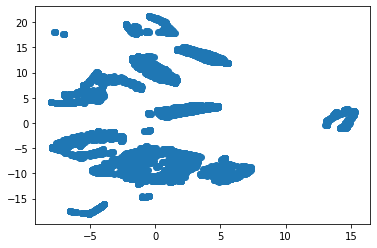

In [11]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.scatter(x=df_embedding['x'], y=df_embedding['y']);

### Save Dataset

This is a good checkpoint to save this preprocessing as the feature engineering has finished here and now we're going to tune the model.

In [12]:
output_folder = 'ml-in-production/data/output/processed'
out_file_name = 'embedding.parquet'
output_bucket_data = f's3://{bucket}/{output_folder}/{out_file_name}'
print(output_bucket_data)


#!if [ ! -d $output_folder ]; then mkdir -p $output_folder; fi

df_embedding.to_parquet(output_bucket_data, engine='pyarrow')

s3://dsla/ml-in-production/data/output/processed/embedding.parquet


## Clustering

A density based model has been chosen for doing the clustering due to the irregular shapes coming from UMAP projection. Here algorithms like KMeans would perform badly as we'll see in following lessons.

### HDBSCAN

In [13]:
import numpy as np
from hdbscan import HDBSCAN
    
hdbscan_m = HDBSCAN(min_cluster_size=50, 
                    metric='euclidean', 
                    prediction_data=True)

clustering = hdbscan_m.fit_predict(df_embedding)

print(f'Cluster Ids: {np.sort(np.unique(clustering))}')

/home/centos/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/centos/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Cluster Ids: [-1  0  1  2  3  4  5  6  7  8  9]


## Results

As output from the clustering we've selected 2 variables: the total number of clusters that HDBSCAN has found and the number of points that HDBSCAN has decided not to include in one of them.

In [14]:
number_of_clusters = len(np.unique(clustering[clustering != -1]))
print(f'Number of Clusters: {number_of_clusters}')

number_of_outliers = len(clustering[clustering == -1])
print(f'Noise: {number_of_outliers}')

Number of Clusters: 10
Noise: 72


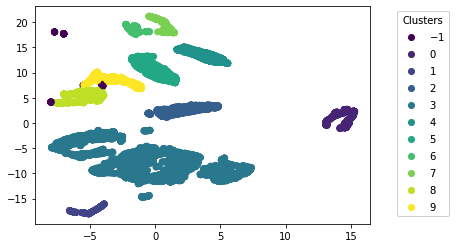

In [15]:
fig, ax = plt.subplots()

scatter = ax.scatter(x=df_embedding['x'], 
                     y=df_embedding['y'],
                     c=clustering)

legend = ax.legend(*scatter.legend_elements(num=number_of_clusters), 
                   title='Clusters', 
                   loc='upper right', 
                   bbox_to_anchor=(1.25,1.0))

ax.add_artist(legend);

image_name  = 'baseline'


#save to local folder
output_folder = '../output/figures/'
!if [ ! -d $output_folder ]; then mkdir -p $output_folder; fi

figure_path=f'{output_folder}/{image_name}.png'
plt.savefig(figure_path)
plt.show()
plt.close()


 

In [16]:
# Upload to S3 instead of saving to local

import io
import boto3 # Amazon's aws library for python 3

# create a connection to s3
s3 = boto3.resource('s3')

# bucket is already defined above 
print(bucket)

# upload image to aws s3
# warning, the ACL here is set to private (not public-read)

print(figure_path)

img_data = open(figure_path, "rb")
print(img_data)

s3.Bucket(bucket).put_object(Key=f'{image_name}.png', Body=img_data, 
                       ContentType="image/png" , ACL="private")

# Generate the URL to get 'key-name' from 'bucket-name'
url = "http://" + bucket + ".s3.amazonaws.com/" + image_name
# this url should open the uploaded image as an image in a browser window   

dsla
../output/figures//baseline.png
<_io.BufferedReader name='../output/figures//baseline.png'>


In order to see how these records have been clustered together, we'll inverse transform the dataset and select the records from one cluster.

In [17]:
df_results = df_umap.copy()

df_results.loc[:,columns_to_encode] = encoder_m.inverse_transform(df_results[columns_to_encode])

df_results[clustering == 0]

,origin,destination,train_type,price,train_class,fare,duration,time_to_departure,hour,weekday
2500995,VALENCIA,MADRID,REGIONAL,28.35,Turista,Adulto ida,7.633333,8,9,1
7750123,VALENCIA,MADRID,REGIONAL,28.35,Turista,Adulto ida,7.633333,17,9,0
8626820,MADRID,VALENCIA,REGIONAL,28.35,Turista,Adulto ida,6.700000,38,16,3
6918060,VALENCIA,MADRID,REGIONAL,28.35,Turista,Adulto ida,7.666667,14,14,2
7929214,VALENCIA,MADRID,REGIONAL,28.35,Turista,Adulto ida,7.700000,53,6,3
...,...,...,...,...,...,...,...,...,...,...
5643889,MADRID,VALENCIA,REGIONAL,28.35,Turista,Adulto ida,6.716667,57,12,2
1165780,VALENCIA,MADRID,REGIONAL,28.35,Turista,Adulto ida,6.983333,40,6,6
8859946,VALENCIA,MADRID,REGIONAL,28.35,Turista,Adulto ida,7.633333,53,9,0
7704935,MADRID,VALENCIA,REGIONAL,28.35,Turista,Adulto ida,6.716667,25,12,1


## Save Models

The last step will be saving all the models that have taken part in the pipeline for further use in following lessons.

In [18]:
import pickle
import boto3

output_folder = '../output/pickle_data'
folder = "ml-in-production/output/pickle_data"

!if [ ! -d $output_folder ]; then mkdir -p $output_folder; fi

s3 = boto3.resource('s3')

with open(f'{output_folder}/encoder.pickle', 'wb') as f:  # 'wb' instead 'w' for binary file
    pickle.dump(encoder_m, f, protocol=None, fix_imports=True)  # -1 specifies highest binary protocol
    s3.Object(bucket, f'{folder}/encoder.pickle').put(Body=f'{output_folder}/encoder.pickle')
    
with open(f'{output_folder}/umap.pickle', 'wb') as f:
    pickle.dump(umap_m, f)
    s3.Object(bucket, f'{folder}/umap.pickle').put(Body=f'{output_folder}/umap.pickle')

with open(f'{output_folder}/hdbscan.pickle', 'wb') as f:
    pickle.dump(hdbscan_m, f)
    s3.Object(bucket, f'{folder}/hdbscan.pickle').put(Body=f'{output_folder}/hdbscan.pickle')